In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import re
import preprocessor as proc
import nltk

from transformers import AutoTokenizer

from src.config import CONFIG
from src.preprocessing import SBICDatasetPreprocessing
from src.train_utils import make_tokinzer
from nltk.corpus import stopwords

nltk.download
nltk.download('wordnet')
nltk.download('stopwords')

2023-10-27 16:47:09.239074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 16:47:09.944145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package wordnet to /home/matteo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/matteo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Inspection

In [5]:
df = pd.read_csv(CONFIG.dataset.train_data_raw)
df.head()

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,HITId,annotatorPolitics,annotatorRace,annotatorAge,post,targetMinority,targetCategory,targetStereotype,dataSource
0,0.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,NaN,-8935932304856669427,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,white,45.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
1,0.0,0.66,0.0,NaN,0.5,man,NaN,NaN,NaN,6347880360297734464,363A7XIFV4G2799C5V96YERJA9AVAM,mod-liberal,white,35.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
2,0.0,0.33,0.0,NaN,0.5,man,NaN,NaN,NaN,-7452610791699819066,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,asian,23.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
3,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,all stupid,t/davidson
4,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,are not people but apes.,t/davidson


In [6]:
print(df.columns)
print(len(df.columns))

Index(['whoTarget', 'intentYN', 'sexYN', 'sexReason', 'offensiveYN',
       'annotatorGender', 'annotatorMinority', 'sexPhrase',
       'speakerMinorityYN', 'WorkerId', 'HITId', 'annotatorPolitics',
       'annotatorRace', 'annotatorAge', 'post', 'targetMinority',
       'targetCategory', 'targetStereotype', 'dataSource'],
      dtype='object')
19


In [7]:
sex_reason = df["sexReason"].unique()
print(sex_reason)
print(len(sex_reason))

[nan 'refers to lots of sexual activity' 'women wanting sex' ...
 'about masturbating' 'directly references masturbation'
 'man with a small penis']
4264


In [8]:
sex_phrase = df["sexPhrase"].unique()
print(sex_phrase)
print(len(sex_phrase))

[nan 'hoe shit' 'hoes bent over' ...
 'I have scoliosis and shoulder higher than the other due to compulsive masturbation'
 'compulsive masturbation'
 'I have scoliosis and shoulder higher than the other due to compulsive masturbation If I had sex that never would have happened.']
5639


In [9]:
print(f"Tolal number of annotations: {len(df)}")
print("\nNumber of NaN values inside columns:")
print(df.isna().sum())

Tolal number of annotations: 112900

Number of NaN values inside columns:
whoTarget             46931
intentYN                  0
sexYN                     0
sexReason            102520
offensiveYN            2017
annotatorGender           1
annotatorMinority     86549
sexPhrase            102507
speakerMinorityYN     67437
WorkerId                  0
HITId                     0
annotatorPolitics         1
annotatorRace             1
annotatorAge              1
post                      0
targetMinority        70406
targetCategory        70406
targetStereotype      71192
dataSource                0
dtype: int64


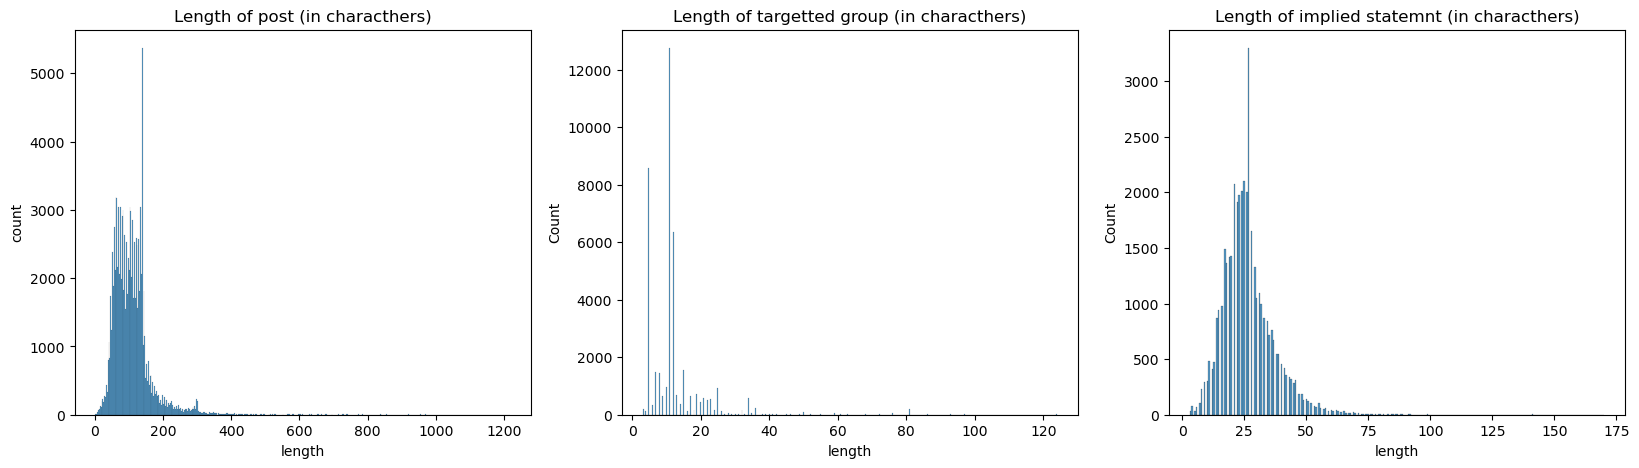

,post_length,group_length,streotype_length
count,112900.000000,112900.000000,112900.000000
mean,109.340425,4.748096,9.820204
std,61.957050,8.707602,14.277202
min,2.000000,0.000000,0.000000
25%,71.000000,0.000000,0.000000
50%,101.000000,0.000000,0.000000
75%,133.000000,11.000000,22.000000
max,1217.000000,124.000000,170.000000


In [10]:
posts_len = df['post'].fillna("").str.len().tolist()
grps_len = df['targetMinority'].fillna("").str.len().tolist()
strps_len = df['targetStereotype'].fillna("").str.len().tolist()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 5))
sns.histplot([len for len in posts_len if len != 0], ax=ax1)
sns.histplot([len for len in grps_len if len != 0], ax=ax2)
sns.histplot([len for len in strps_len if len != 0], ax=ax3)
ax1.set_title("Length of post (in characthers)")
ax2.set_title("Length of targetted group (in characthers)")
ax3.set_title("Length of implied statemnt (in characthers)")
ax1.set_xlabel("length")
ax2.set_xlabel("length")
ax3.set_xlabel("length")
ax1.set_ylabel("count")
plt.show()

tmp = pd.DataFrame(list(zip(posts_len, grps_len, strps_len)), columns=["post_length", "group_length", "streotype_length"])
display(tmp.describe())

In [14]:
tokenizer = AutoTokenizer.from_pretrained(CONFIG.checkpoints.distilgpt2,
                                          padding_side=CONFIG.model_params.padding_side,
                                          use_fast=True)

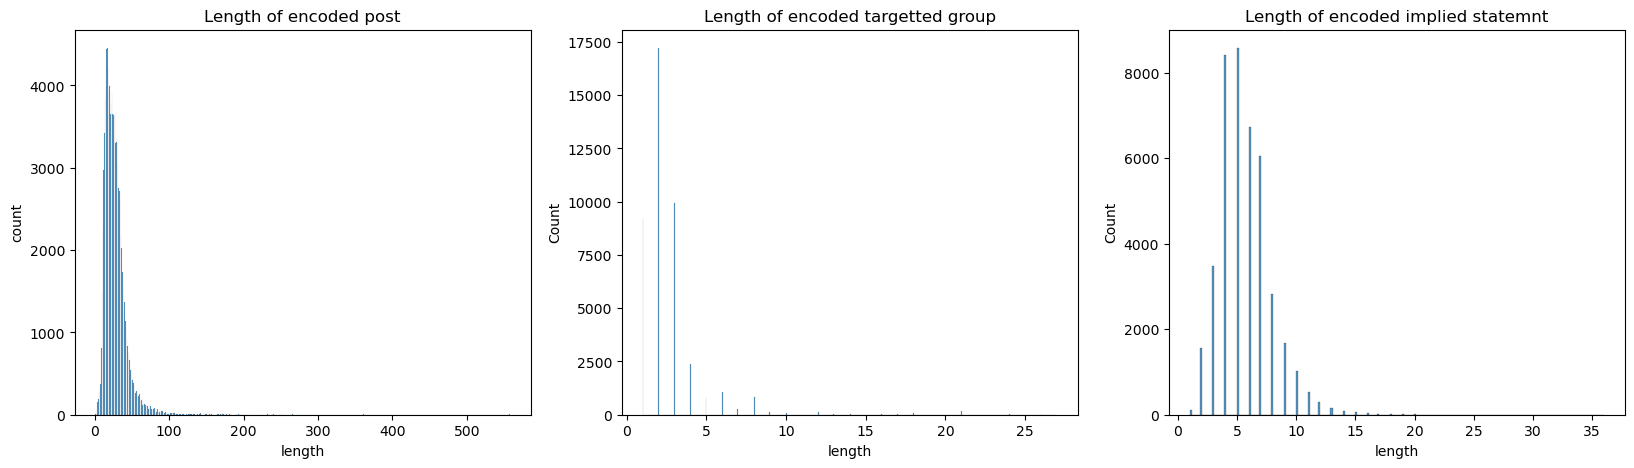

,encoded_post_length,encoded_group_length,encoded_streotype_length
count,112900.000000,112900.000000,112900.000000
mean,27.594198,1.014331,2.096457
std,16.773132,1.964257,3.055493
min,1.000000,0.000000,0.000000
25%,17.000000,0.000000,0.000000
50%,25.000000,0.000000,0.000000
75%,33.000000,2.000000,4.000000
max,558.000000,27.000000,36.000000


In [15]:
enc_posts = tokenizer(df['post'].fillna("").tolist())["input_ids"]
enc_groups = tokenizer(df['targetMinority'].fillna("").tolist())["input_ids"]
enc_stereotypes = tokenizer(df['targetStereotype'].fillna("").tolist())["input_ids"]

len_enc_posts = [len(enc) for enc in enc_posts]
len_enc_groups = [len(enc) for enc in enc_groups]
len_enc_stereotypes = [len(enc) for enc in enc_stereotypes]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 5))
sns.histplot([len for len in len_enc_posts if len != 0], ax=ax1)
sns.histplot([len for len in len_enc_groups if len != 0], ax=ax2)
sns.histplot([len for len in len_enc_stereotypes if len != 0], ax=ax3)
ax1.set_title("Length of encoded post (in tokens)")
ax2.set_title("Length of encoded targetted group (in tokens)")
ax3.set_title("Length of encoded implied statemnt (in tokens)")
ax1.set_xlabel("length")
ax2.set_xlabel("length")
ax3.set_xlabel("length")
ax1.set_ylabel("count")
plt.show()

tmp = pd.DataFrame(list(zip(len_enc_posts, len_enc_groups, len_enc_stereotypes)), columns=["encoded_post_length", "encoded_group_length", "encoded_streotype_length"])
display(tmp.describe())

In the worst case, if we take all these three element considering their respective maximum length, the input would be $558 + 27 + 36 = 621$ tokens long and it's very far from the $1024$ GPT2 input max lenght. At this point, we are sure that no one post will be truncated when it will passed to the model as input.

## Data Preprocessing

In [3]:
textFields = ['targetGroup', 'targetStereotype']
classFields = ['offensiveYN', 'intentYN', 'sexYN','groupTargetYN']
columns_to_drop=["sexReason", "annotatorGender", "annotatorMinority", "sexPhrase", "WorkerId", "HITId", "annotatorPolitics", "annotatorRace", "annotatorAge", "targetCategory"]

preproc = SBICDatasetPreprocessing(textFields=textFields,
                                   classFields=classFields,
                                   columns_to_drop=columns_to_drop
)

### NaN Preprocessing

As first preprocessing, we will remove those data that will not be used during training or inference time. Reorder also the columns to had better comprension of the data

In [20]:
df_red = preproc.prepare_columns_for_train(df)
df_red.head()

,post,offensiveYN,intentYN,sexYN,groupTargetYN,targetGroup,targetStereotype,inGroupYN,dataSource
0,RT @_LexC__: I'm convinced that some of y'all ...,1.0,0.66,0.0,0.0,NaN,NaN,NaN,t/davidson
1,RT @_LexC__: I'm convinced that some of y'all ...,0.5,0.66,0.0,0.0,NaN,NaN,NaN,t/davidson
2,RT @_LexC__: I'm convinced that some of y'all ...,0.5,0.33,0.0,0.0,NaN,NaN,NaN,t/davidson
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1.0,1.00,0.0,1.0,black folks,all stupid,0.0,t/davidson
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1.0,1.00,0.0,1.0,black folks,are not people but apes.,0.0,t/davidson


In [26]:
df_red = preproc.remove_nan_annotation(df_red)

post                    0
offensiveYN             0
intentYN                0
sexYN                   0
groupTargetYN       45023
targetGroup         66750
targetStereotype    67536
inGroupYN           65376
dataSource              0
dtype: int64

Number of post that have NaN offensive label: 0 (0.0 %)


As you can see, there are several nan in latest columns, due to the fact that a not offensive post, must not have these fields filled. At the same time, columns like *offensiveYN* should not present at all. Since, they are very few and tehy could lead to error during the training, we decide to drop them.

The presence of so many nan values in *groupTargetYN* can be justify because, a not offensive post don't have this field filled during annotation. In order to have better understanding od the data, plot some statistics:

In [28]:
df_red = preproc.remove_nan_group(df_red)

Total not offensive annotations: 	45023
Total nan values:			45023
Total nan values with offensive=0:	45023
Total nan values with offensive=1:	0


All NaN values in *groupTargetYN* are due to the presence of annotation with offensiveness set to zero. At the same time, not all not offensive annotations have set to NaN this column. So, we drop this features.

At this point, we had to check the correctness of the *targetGroup* and *targetStereotype* columns. They should have a NaN values if:
- a post is not considered not offensive
- if the *groupTargetYN* field had a value equal to 0

So, in order to check, we want understand how many annotation break these rules.

In [35]:
df_red = preproc.remove_nan_group_and_stereotype(df_red)

Analysis of targetGroup columns
Total not nan values if offensive=0:	0
Total not nan values if group=0:	0

Analysis of targetStereotype columns
Total not nan values if offensive=0:	0
Total not nan values if group=0:	0
Total nan values a group is set:	0


As you can see, there are some annotations that don't follow the rule and as we did previous, we drop it.

For the last columns *inGroupYN* we cannot infer any prior knowledge, so we don't preprocess its. At the end, in order to have correct data for training, we fill all the remaining NaN values in the following way:
- a placeholder equal to 2 for *groupTargetYN* and *inGroupYN* columns
- an empty string for the group and the stereotype

In [36]:
df_red[["groupTargetYN", "inGroupYN"]] = df_red[["groupTargetYN", "inGroupYN"]].fillna(2)
df_red[["targetGroup", "targetStereotype"]] = df_red[["targetGroup", "targetStereotype"]].fillna("")
display(df_red.isna().sum())

post                0
offensiveYN         0
intentYN            0
sexYN               0
groupTargetYN       0
targetGroup         0
targetStereotype    0
inGroupYN           0
dataSource          0
dtype: int64

Binarize classification variable

In [42]:
df_red = preproc.binarize_classification_features(df_red)

display(df_red.head())
df_red.to_pickle(CONFIG.dataset.train_data_preproc)
print(f"Element removed during pre-processing: {len(df)-len(df_red)} ({(len(df)-len(df_red))/len(df):.2%})")

,post,offensiveYN,intentYN,sexYN,groupTargetYN,targetGroup,targetStereotype,inGroupYN,dataSource
0,RT @_LexC__: I'm convinced that some of y'all ...,1,1,0,0,,,2.0,t/davidson
1,RT @_LexC__: I'm convinced that some of y'all ...,1,1,0,0,,,2.0,t/davidson
2,RT @_LexC__: I'm convinced that some of y'all ...,1,0,0,0,,,2.0,t/davidson
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1,1,0,1,black folks,all stupid,0.0,t/davidson
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1,1,0,1,black folks,are not people but apes.,0.0,t/davidson


Element removed during pre processing: 4568 (4.05%)


We decided to apply all the preprocessing to both validation and test split, beacuse we want that our network will be not penalized during evaluation beacuse of bad annotation present in the set. All the steps are the same except from for the NaN filling of  *groupTargetYN*, *inGroupYN* columns, that were filled with 0.5. This choice was taken because the evaluation will be performed over aggregated data (multiple annotation are collpsed into only one) and for classification field an average over the value will be executed. 

In [11]:
val_df = pd.read_csv(CONFIG.dataset.val_data_raw)
test_df = pd.read_csv(CONFIG.dataset.test_data_raw)

val_df_red = preproc.preproc_data(val_df, "validation")
test_df_red = preproc.preproc_data(test_df, "test")

Element removed during pre-processing validation split:	640 (3.82%)
Element removed during pre-processing test split:	632 (3.61%)


### Validation and Test data preparation


In [4]:
df_train = pd.read_pickle(CONFIG.dataset.train_data_preproc)
df_val = pd.read_pickle(CONFIG.dataset.val_data_preproc)
df_test = pd.read_pickle(CONFIG.dataset.test_data_preproc)

df_val.head()

,post,offensiveYN,intentYN,sexYN,groupTargetYN,targetGroup,targetStereotype,inGroupYN,dataSource
0,Every half-breed cop in America is trying to r...,1.0,1.0,0.0,1.0,police officers,rape women,0.0,t/davidson
2,Every half-breed cop in America is trying to r...,1.0,1.0,1.0,1.0,mixed folks,mixed folks are rapists.,0.0,t/davidson
3,Every half-breed cop in America is trying to r...,1.0,1.0,1.0,1.0,mixed folks,mixed folks like white women.,0.0,t/davidson
4,Every half-breed cop in America is trying to r...,1.0,1.0,1.0,1.0,cops,cops can't be trusted.,0.0,t/davidson
5,Every half-breed cop in America is trying to r...,1.0,1.0,1.0,1.0,cops,cops are rapists.,0.0,t/davidson


As first step, let's check whether there is an overlapping between sets...

In [5]:
num_train_val_overlap, df_val = preproc.remove_overlap_data(df_train, df_val)
num_train_test_overlap, df_test = preproc.remove_overlap_data(df_train, df_test)
num_val_test_overlap, df_test = preproc.remove_overlap_data(df_val, df_test)

print("Overlapping annotation between train and val:\t", num_train_val_overlap)
print("Overlapping annotation between train and test:\t", num_train_test_overlap)
print("Overlapping annotation between val and test:\t", num_val_test_overlap)

Overlapping annotation between train and val:	 295
Overlapping annotation between train and test:	 329
Overlapping annotation between val and test:	 34


As you can see, there are some data that overlap between sets. This could lead to a better performance of the model in the evaluation phase, so we drop these elements from validation and test set. This will result in more robust scores.

As mentioned before, we decide to aggregate data for evaluation. This decesion was taken beacuse we are not interested to predict multiple annotation to a post. Indeed, at the end we don't care to predict a post with annotation A and an annotation B well. Instead, is more interesting that from multiple annotation model, can learn to generalize over different point of view and produce an output that is the mean. To do so, we aggregate annotation for both validation and test split. 

In [6]:
df_val_agg = preproc.data_aggregator(df_val)
df_test_agg = preproc.data_aggregator(df_test)

df_val_agg.to_pickle(CONFIG.dataset.val_data_agg)
df_test_agg.to_pickle(CONFIG.dataset.test_data_agg)

df_val_agg

,post,offensiveYN,intentYN,sexYN,groupTargetYN,targetGroup,targetStereotype,inGroupYN,dataSource
0,\nRed Nation Rising\n‏\n\n \n@RedNationRising...,0,0,0,2,[],[],2,{Gab}
1,"they found marijuana, butane hash oil (BHO) a...",0,0,0,0,[],[],2,{Gab}
2,""""""" I have no problem being called Benny! Just...",1,1,0,0,[],[],2,{t/founta}
3,""""""" animal friend in My ass"""" You need some He...",1,1,0,0,[],[],2,{t/founta}
4,"""""""A mans belly shall be satisfied with the fr...",0,0,0,2,[],[],2,{t/founta}
...,...,...,...,...,...,...,...,...,...
4568,“One special advantage of the skeptical attitu...,0,0,0,2,[],[],2,{t/founta}
4569,“The only thing worse than living in a country...,1,1,0,1,"[black folks, asian folks, latino/latina folks...",[non-white people ruin the life of white peopl...,0,{Gab}
4570,“Two things are infinite: the universe and hum...,0,0,0,0,[],[],2,{Gab}
4571,♪ &#9835; ♬ believe it or not i 'm gassing the...,1,1,0,1,[jewish folks],"[all jews have big noses, died in the holocaus...",0,{r/meanjokes}


Once obtained the aggregated dataset, we faced with a huge problem. Now, for the targetted group and the stereotype we had a list of string. Choosing the best could be very difficult, but for the moment we keep all of them and we choose the one with the highest score during evaluation

### Post Preprocessing

In [ ]:
df = pd.read_pickle(CONFIG.dataset.train_data_preproc)
df.head()

,post,offensiveYN,intentYN,sexYN,groupTargetYN,targetGroup,targetStereotype,inGroupYN,dataSource
0,RT @_LexC__: I'm convinced that some of y'all ...,1,1,0,0,,,2,t/davidson
1,RT @_LexC__: I'm convinced that some of y'all ...,1,1,0,0,,,2,t/davidson
2,RT @_LexC__: I'm convinced that some of y'all ...,1,0,0,0,,,2,t/davidson
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1,1,0,1,black folks,all stupid,0,t/davidson
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1,1,0,1,black folks,are not people but apes.,0,t/davidson


In [ ]:
#HappyEmoticons
emoticons = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3', ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE) 

html_pattern = re.compile(r"&.*?;")

In [ ]:
def clean_tweets(tweet):
    
    stop_words = set(stopwords.words('english'))
    # word_tokens = word_tokenize(tweet)
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    tweet = proc.clean(tweet)

    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)

    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #remove emojis from tweet

    tweet = emoji_pattern.sub(r'', tweet)
    tweet = html_pattern.sub(r'', tweet)

    #filter using NLTK library append it to a string
    # filtered_tweet = [w for w in tweet.split(" ") if not w in stop_words]
    
    return tweet

    # filtered_tweet = []


    # #looping through conditions
    # for w in tweet.split(" "):
    # #check tokens against stop words , emoticons and punctuations
    #     if w not in stop_words and w not in emoticons and w not in string.punctuation:
    #         filtered_tweet.append(w)

    # return ' '.join(filtered_tweet)

In [ ]:
print(df.iloc[0]["post"])
df["post"] = df["post"].apply(lambda x: clean_tweets(x))
print(df.iloc[0]["post"])

RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because "birth control &amp; plan b pills" are effective &#128533;&#128056;&#9749;&#65039;
 I'm convinced that some of y'all bitches get pregnant purposely because "birth control  plan b pills" are effective 


In [ ]:
df = df.drop(columns=["dataSource"], axis=1)
df.to_pickle(CONFIG.dataset.train_data)